In [6]:
import numpy as np

from src.environments import GridWorldEnv
from src.agents.ql import QLearning, FHQLearning
from src.agents.dp import BackwardPropagation, FrontPolicyImprovement, BackPolicyImprovement
from src.utils import Discretizer
from src.trainer import run_experiment
from src.plots import plot_gridworld

import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import parafac
from src.models import PARAFAC

from itertools import product

import torch
from tensorly.tenalg import khatri_rao

from src.agents.bcd_grid import bcd, bcgd

import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter, MaxNLocator
import pickle

RANK ANALISYS FOR Q*

In [7]:
ENV = GridWorldEnv()

bp_learner = BackwardPropagation(ENV.H,ENV.nS,ENV.nA,ENV.R,ENV.P)

_ = bp_learner.run()
Q_opt =  bp_learner.Q

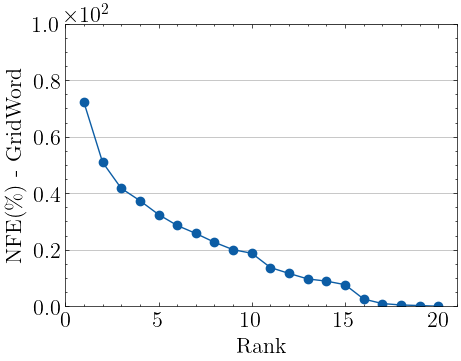

<Figure size 350x262.5 with 0 Axes>

In [3]:
from src.plots import plot_gridworld, plot_errors, plot_tensor_rank

plot_tensor_rank(Q_opt, None)

POLICY EVALUATION WITH BCD

In [14]:

k_list = [10,20,30,50]
scale = 0.7
num_iter = 50

discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[5,5],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)

Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1

fo_list = []
errors_list = []
conv_list = []

for k in k_list:
    Q = PARAFAC(
            np.concatenate(
                [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
            ),
            k=k,
            scale= scale,
            nA=len(discretizer.bucket_actions),
        ).double()
    
    bcd_inv = bcd(Q,Pi,discretizer,ENV,k,Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA))

    fo_values,errors,convs, Q = bcd_inv.run(num_iter)
    fo_list.append(fo_values)
    errors_list.append(errors)
    conv_list.append(convs)

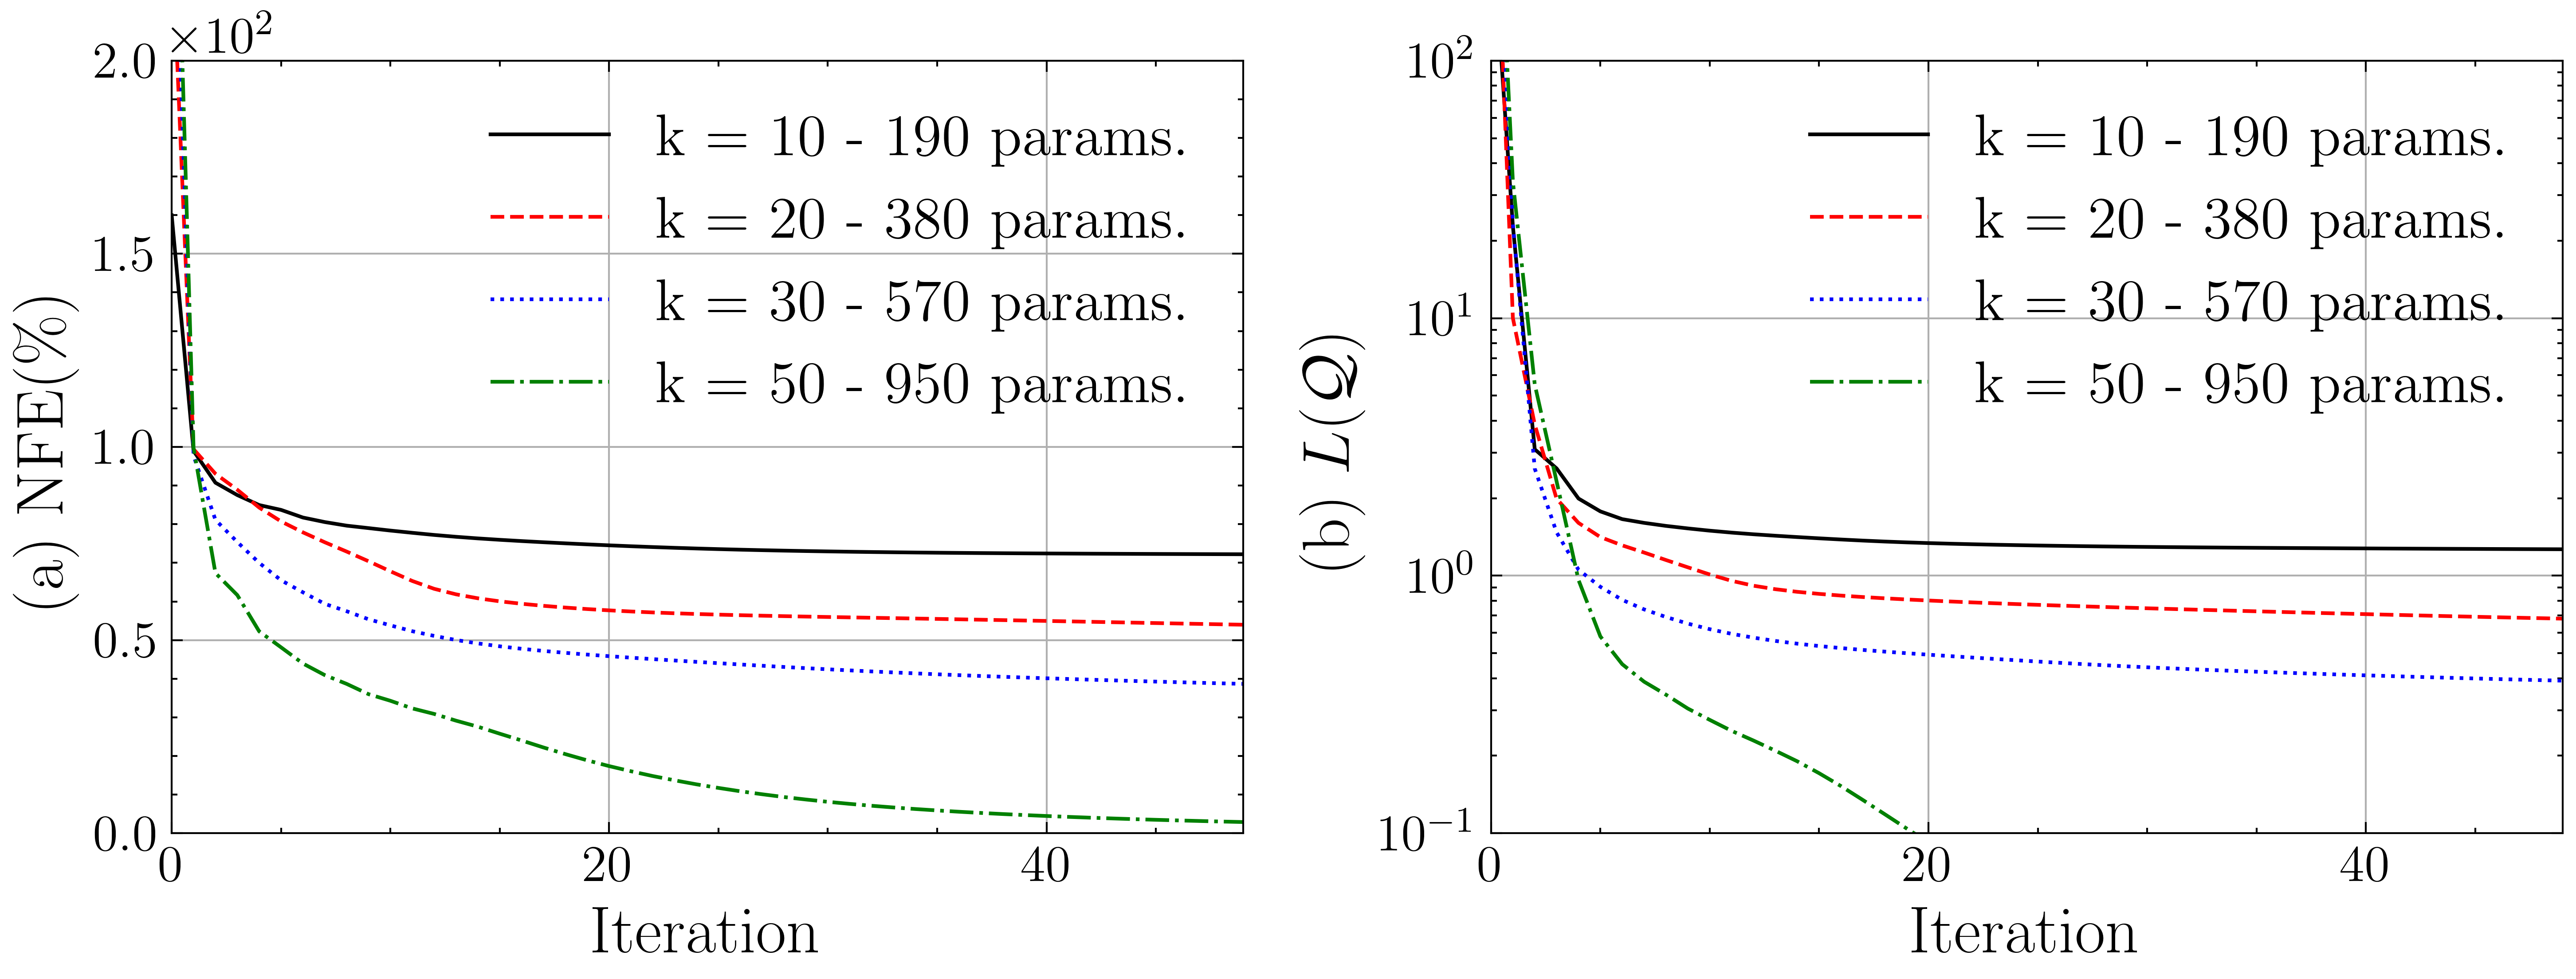

In [15]:

# Crear subplots
with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 4])
    plt.rc('legend', fontsize=16)    # legend fontsize

    for k in range(len(k_list)):
        fo_values = fo_list[k]
        errors = errors_list[k]
        convs = conv_list[k]

        # Segundo subplot: Coseno
        axes[0].plot(errors/(np.linalg.norm(Q_opt)/100),label = f"k = {k_list[k]} - {(ENV.W*2  + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[0].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[0].set_xlim(0, num_iter-1)
        axes[0].set_ylim(0, 200)
        axes[0].set_xlabel("Iteration",fontsize=18)
        axes[0].set_ylabel("(a) NFE(\%)",fontsize=18)
        axes[0].legend(loc='upper right')
        axes[0].grid(True)

        # Tercer subplot: Tangente
        axes[1].plot(fo_values ,label = f"k = {k_list[k]} - {(ENV.W*2 + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[1].set_xlim(0, num_iter-1)
        axes[1].set_ylim(0.1, 100)
        axes[1].set_xlabel("Iteration",fontsize=18)
        axes[1].set_ylabel(r"(b) $ L (\mathcal{Q})$ ",fontsize=18)
        axes[1].set_yscale('log')
        axes[1].legend(loc='upper right')
        axes[1].grid(True)

    # Ajustar el espacio entre subplots
    plt.tight_layout()

    # Mostrar la figura
    plt.show()

POLICY EVALUATION WITH BCGD

In [ ]:
# GridWorld
k_list = [10, 20, 30, 50]
scale = 0.5
num_iter = 10000
alpha = 10e-3

discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[5,5],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)


Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1

fo_list = []
errors_list = []
conv_list = []

for k in k_list:
    Q = PARAFAC(
            np.concatenate(
                [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
            ),
            k=k,
            scale= scale,
            nA=len(discretizer.bucket_actions),
        ).double()
    
    bcd_grad = bcgd(Q,Pi,discretizer,ENV,k,Q_opt.reshape(ENV.H,5,5,ENV.nA),alpha)

    fo_values,errors,convs, Q = bcd_grad.run(num_iter)
    fo_list.append(fo_values)
    errors_list.append(errors)
    conv_list.append(convs)

In [ ]:
with open('bcgd.pkl', 'rb') as f:

    data = pickle.load(f) # deserialize using load()

fo_list = data[0]
errors_list = data[1]
conv_list = data[2]

k_list = [10, 20, 30, 50]
num_iter = 100000

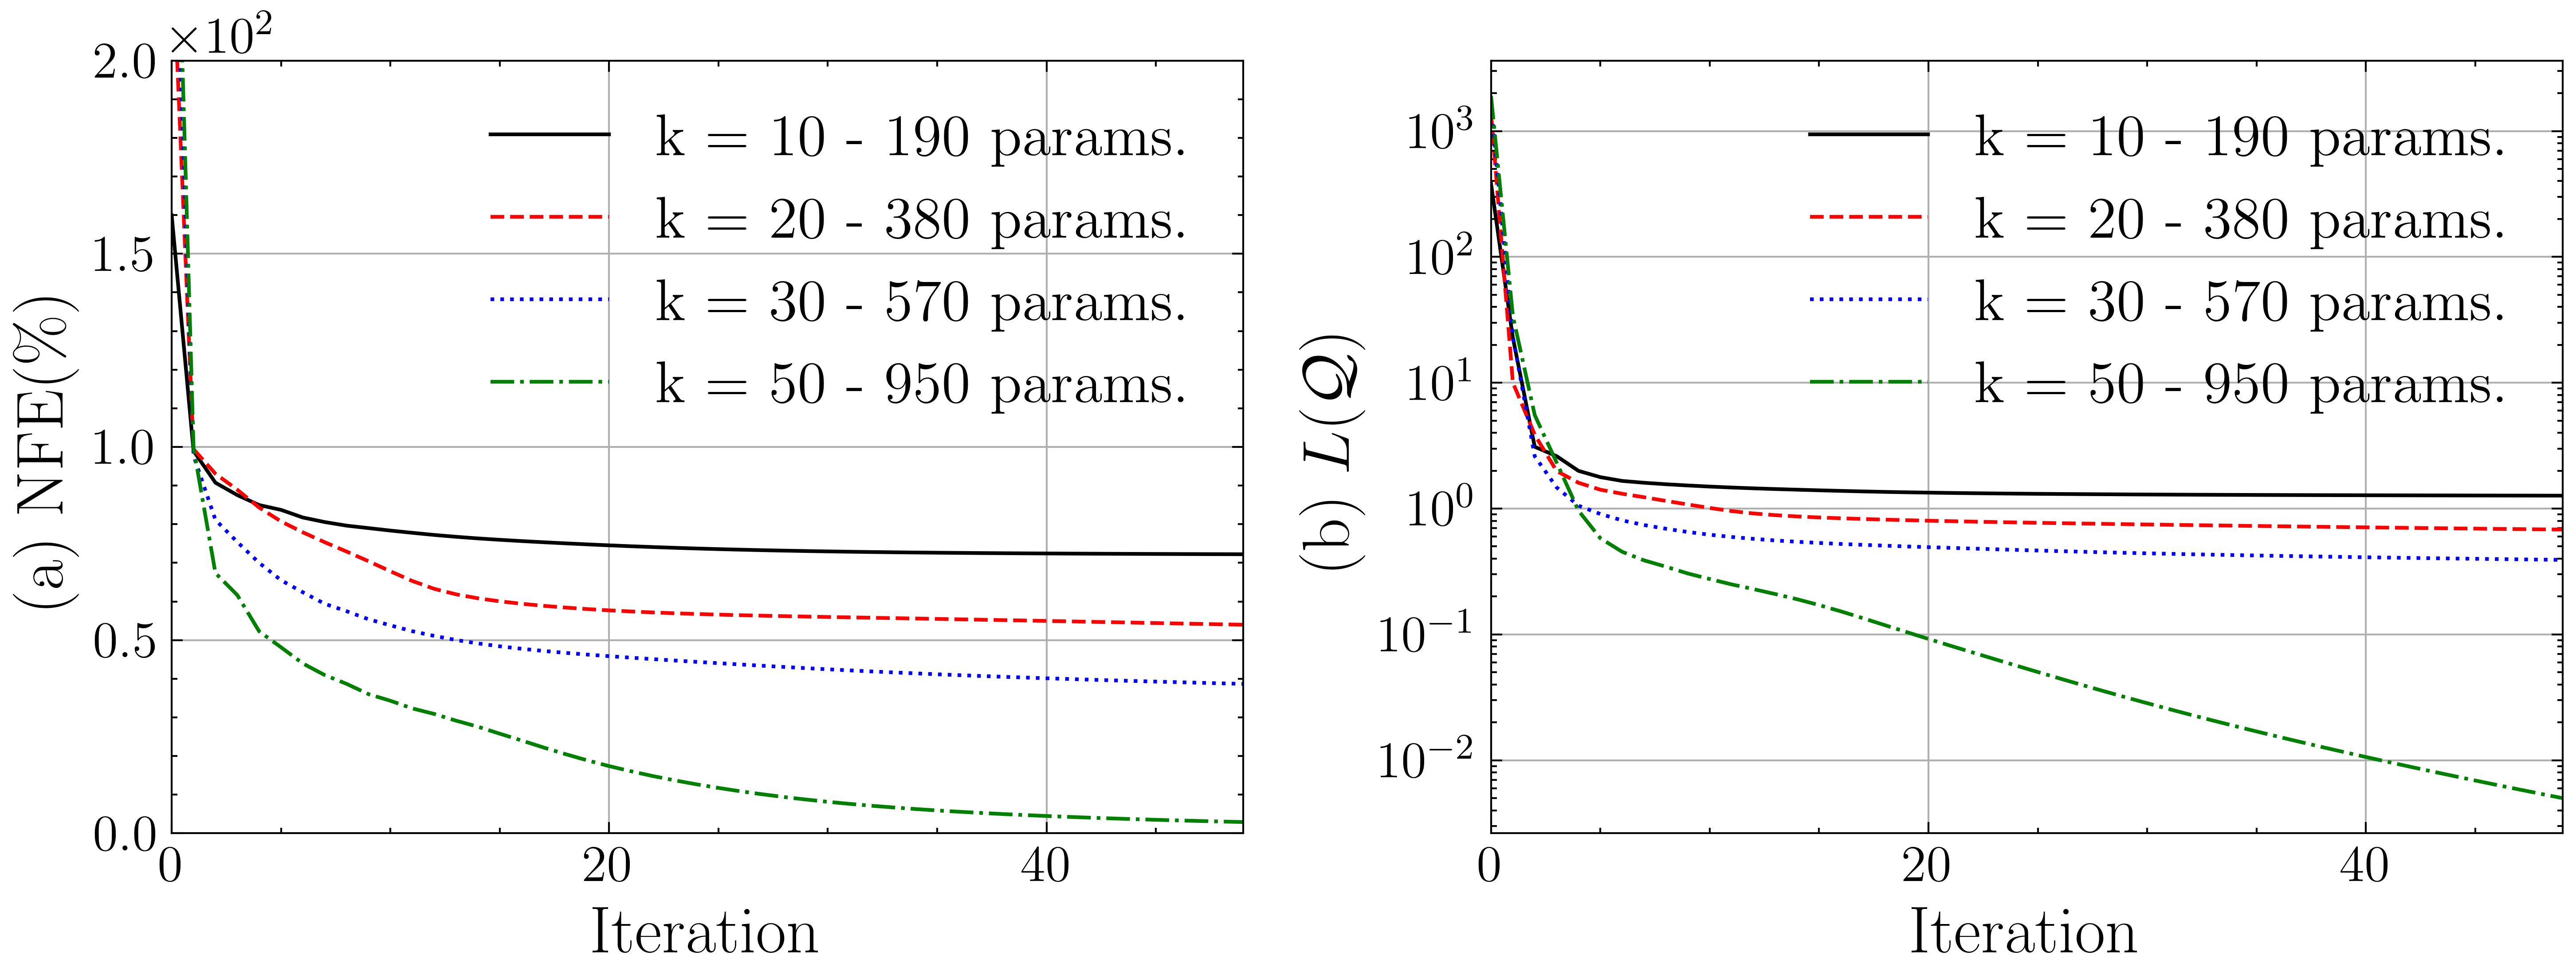

In [19]:

# Crear subplots
with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 4])
    plt.rc('legend', fontsize=16)    # legend fontsize

    for k in range(len(k_list)):
        fo_values = fo_list[k]
        errors = errors_list[k]
        convs = conv_list[k]

        # Segundo subplot: Coseno
        axes[0].plot(errors/(np.linalg.norm(Q_opt)/100),label = f"k = {k_list[k]} - {(ENV.W*2  + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[0].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[0].set_xlim(0, num_iter -1)
        axes[0].set_ylim(0, 200)
        axes[0].set_xlabel("Iteration",fontsize=18)
        axes[0].set_ylabel("(a) NFE(\%)",fontsize=18)
        axes[0].legend(loc='upper right')
        axes[0].grid(True)

        # Tercer subplot: Tangente
        axes[1].plot(fo_values ,label = f"k = {k_list[k]} - {(ENV.W*2 + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[1].set_xlim(0, num_iter-1)
        #axes[1].set_ylim(0.1, 100)
        axes[1].set_xlabel("Iteration",fontsize=18)
        axes[1].set_ylabel(r"(b) $ L (\mathcal{Q})$ ",fontsize=18)
        axes[1].set_yscale('log')
        axes[1].legend(loc='upper right')
        axes[1].grid(True)

    # Ajustar el espacio entre subplots
    plt.tight_layout()

    # Mostrar la figura
    plt.show()

BCD - Policy Evaluation

In [4]:
k_list = [10, 20, 30, 50]
scale = 0.7
bcd_num_iter = 5
policy_num_iter = 100

ENV = GridWorldEnv()

discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[5,5],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)

Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1


fo_list = []
errors_list = []
conv_list = []
returns_mean_list = []
returns_std_list = []

for k in k_list:
    Q = PARAFAC(
                np.concatenate(
                    [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
                ),
                k=k,
                scale= scale,
                nA=len(discretizer.bucket_actions),
            ).double()

    bcd_inv = bcd(Q,Pi,discretizer,ENV,k,Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA))

    fo_values,errors,convs,returns_mean,returns_std, Q = bcd_inv.bcd_policy_improvement(policy_num_iter,bcd_num_iter)
    fo_list.append(fo_values)
    errors_list.append(errors)
    conv_list.append(convs)
    returns_mean_list.append(returns_mean)
    returns_std_list.append(returns_std)

In [27]:
with open('policy-bcd.pkl', 'rb') as f:

    data = pickle.load(f) # deserialize using load()

fo_list = data[0]
errors_list = data[1]
conv_list = data[2]
returns_mean_list = data[3]
returns_std_list = data[4]

k_list = [10, 20, 30, 50]
policy_num_iter = 100

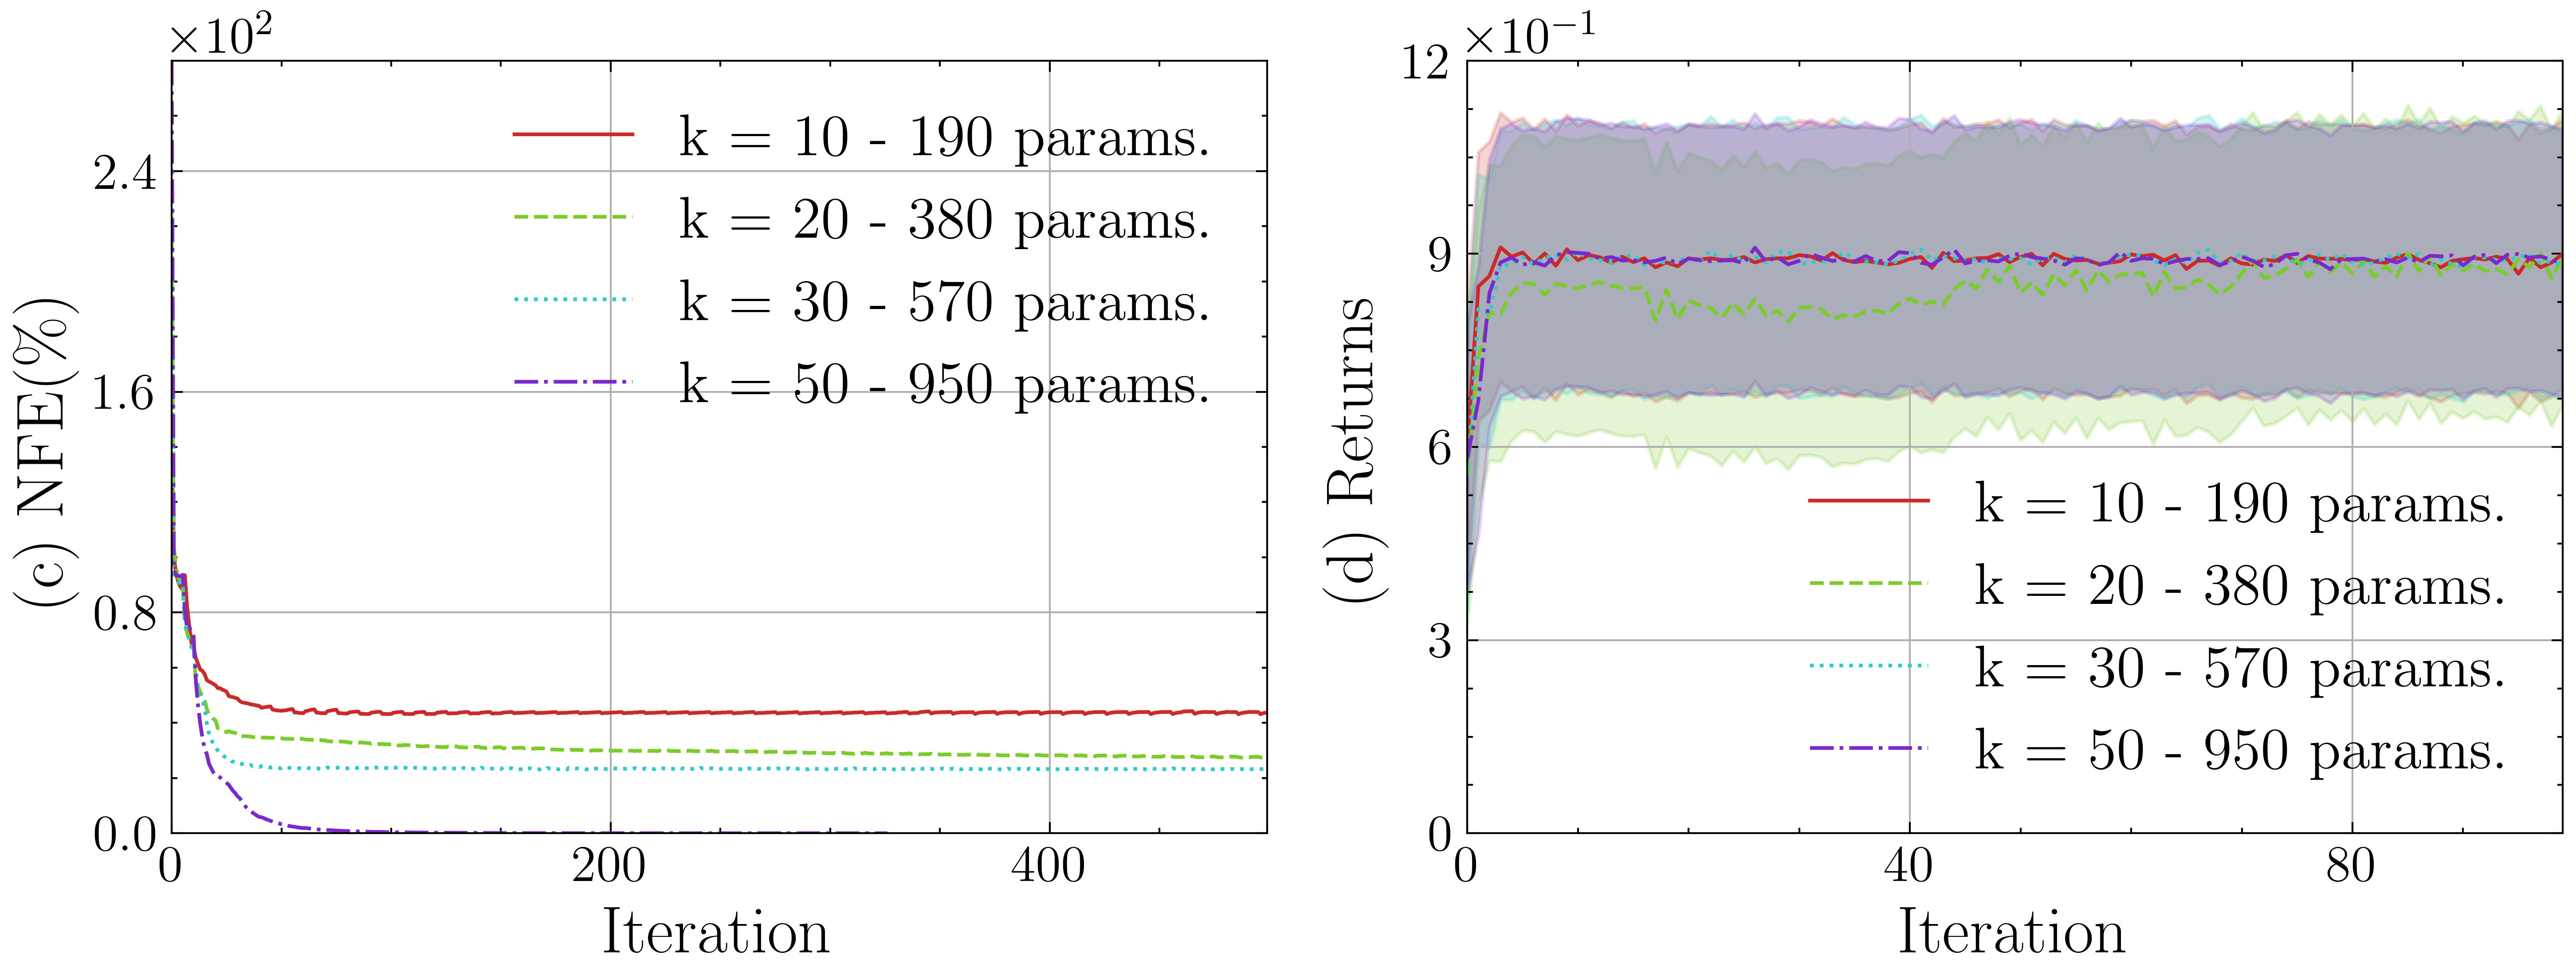

In [28]:
def generate_random_colors(num_colors):
    # Generar valores de matiz (H)
    hue_values = np.linspace(0, 1, num_colors, endpoint=False)

    # Fijar saturación (S) y valor (V) para obtener colores brillantes
    saturation = 0.8
    value = 0.8

    # Convertir de HSV a RGB
    hsv_colors = np.ones((num_colors, 3))
    hsv_colors[:, 0] = hue_values
    hsv_colors[:, 1] = saturation
    hsv_colors[:, 2] = value
    rgb_colors = matplotlib.colors.hsv_to_rgb(hsv_colors)

    return rgb_colors

colors = generate_random_colors(len(k_list))
x_lim = 0
for errors in errors_list:
    if len(errors) > x_lim:
        x_lim = len(errors)
# Crear subplots
with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 4])
    plt.rc('legend', fontsize=16)    # legend fontsize

    for k in range(len(k_list)):
        fo_values = fo_list[k]
        errors = errors_list[k]
        convs = conv_list[k]
        returns_mean = np.array(returns_mean_list[k])
        returns_std = np.mean(returns_std_list[k])

        # Segundo subplot: Coseno
        axes[0].plot(errors/(np.linalg.norm(Q_opt)/100),color = colors[k],label = f"k = {k_list[k]} - {(ENV.W*2  + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[0].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[0].set_xlim(0, x_lim -1)
        axes[0].set_ylim(0, 280)
        axes[0].set_xlabel("Iteration",fontsize=18)
        axes[0].set_ylabel("(c) NFE(\%)",fontsize=18)
        axes[0].legend(loc='upper right')
        axes[0].grid(True)

        # Tercer subplot: Tangente
        axes[1].plot(returns_mean , color = colors[k], label = f"k = {k_list[k]} - {(ENV.W*2 + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[1].fill_between(
            range(len(returns_mean)),  # Eje X: índices de los valores
            returns_mean - returns_std,  # Límite inferior
            returns_mean + returns_std,  # Límite superior
            color=colors[k], alpha=0.2  # Opcional: color y transparencia
        )
        axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[1].set_xlim(0, policy_num_iter - 1)
        axes[1].set_ylim(0, 1.2)
        axes[1].set_xlabel("Iteration",fontsize=18)
        axes[1].set_ylabel(r"(d) Returns ",fontsize=18)
        axes[1].legend(loc='lower right')
        axes[1].grid(True)

    # Ajustar el espacio entre subplots
    plt.tight_layout()

    # Mostrar la figura
    plt.show()

In [5]:
k_list = [50]
scale = 0.7
bcd_num_iter = 100
policy_num_iter = 50
alpha = 10e-3

ENV = GridWorldEnv()

discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[5,5],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)

Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1


fo_list = []
errors_list = []
conv_list = []
returns_mean_list = []
returns_std_list = []

for k in k_list:
    Q = PARAFAC(
                np.concatenate(
                    [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
                ),
                k=k,
                scale= scale,
                nA=len(discretizer.bucket_actions),
            ).double()

    bcd_grad = bcgd(Q,Pi,discretizer,ENV,k,Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA),alpha)
    fo_values,errors,convs,returns_mean,returns_std, Q = bcd_grad.bcgd_policy_improvement(policy_num_iter,bcd_num_iter)
    fo_list.append(fo_values)
    errors_list.append(errors)
    conv_list.append(convs)
    returns_mean_list.append(returns_mean)
    returns_std_list.append(returns_std)

In [ ]:
with open('exp1.pkl', 'rb') as f:

    data = pickle.load(f) # deserialize using load()

fo_list = data[0]
errors_list = data[1]
conv_list = data[2]
returns_mean_list = data[3]
returns_std_list = data[4]

k_list = [10, 20, 30, 50]

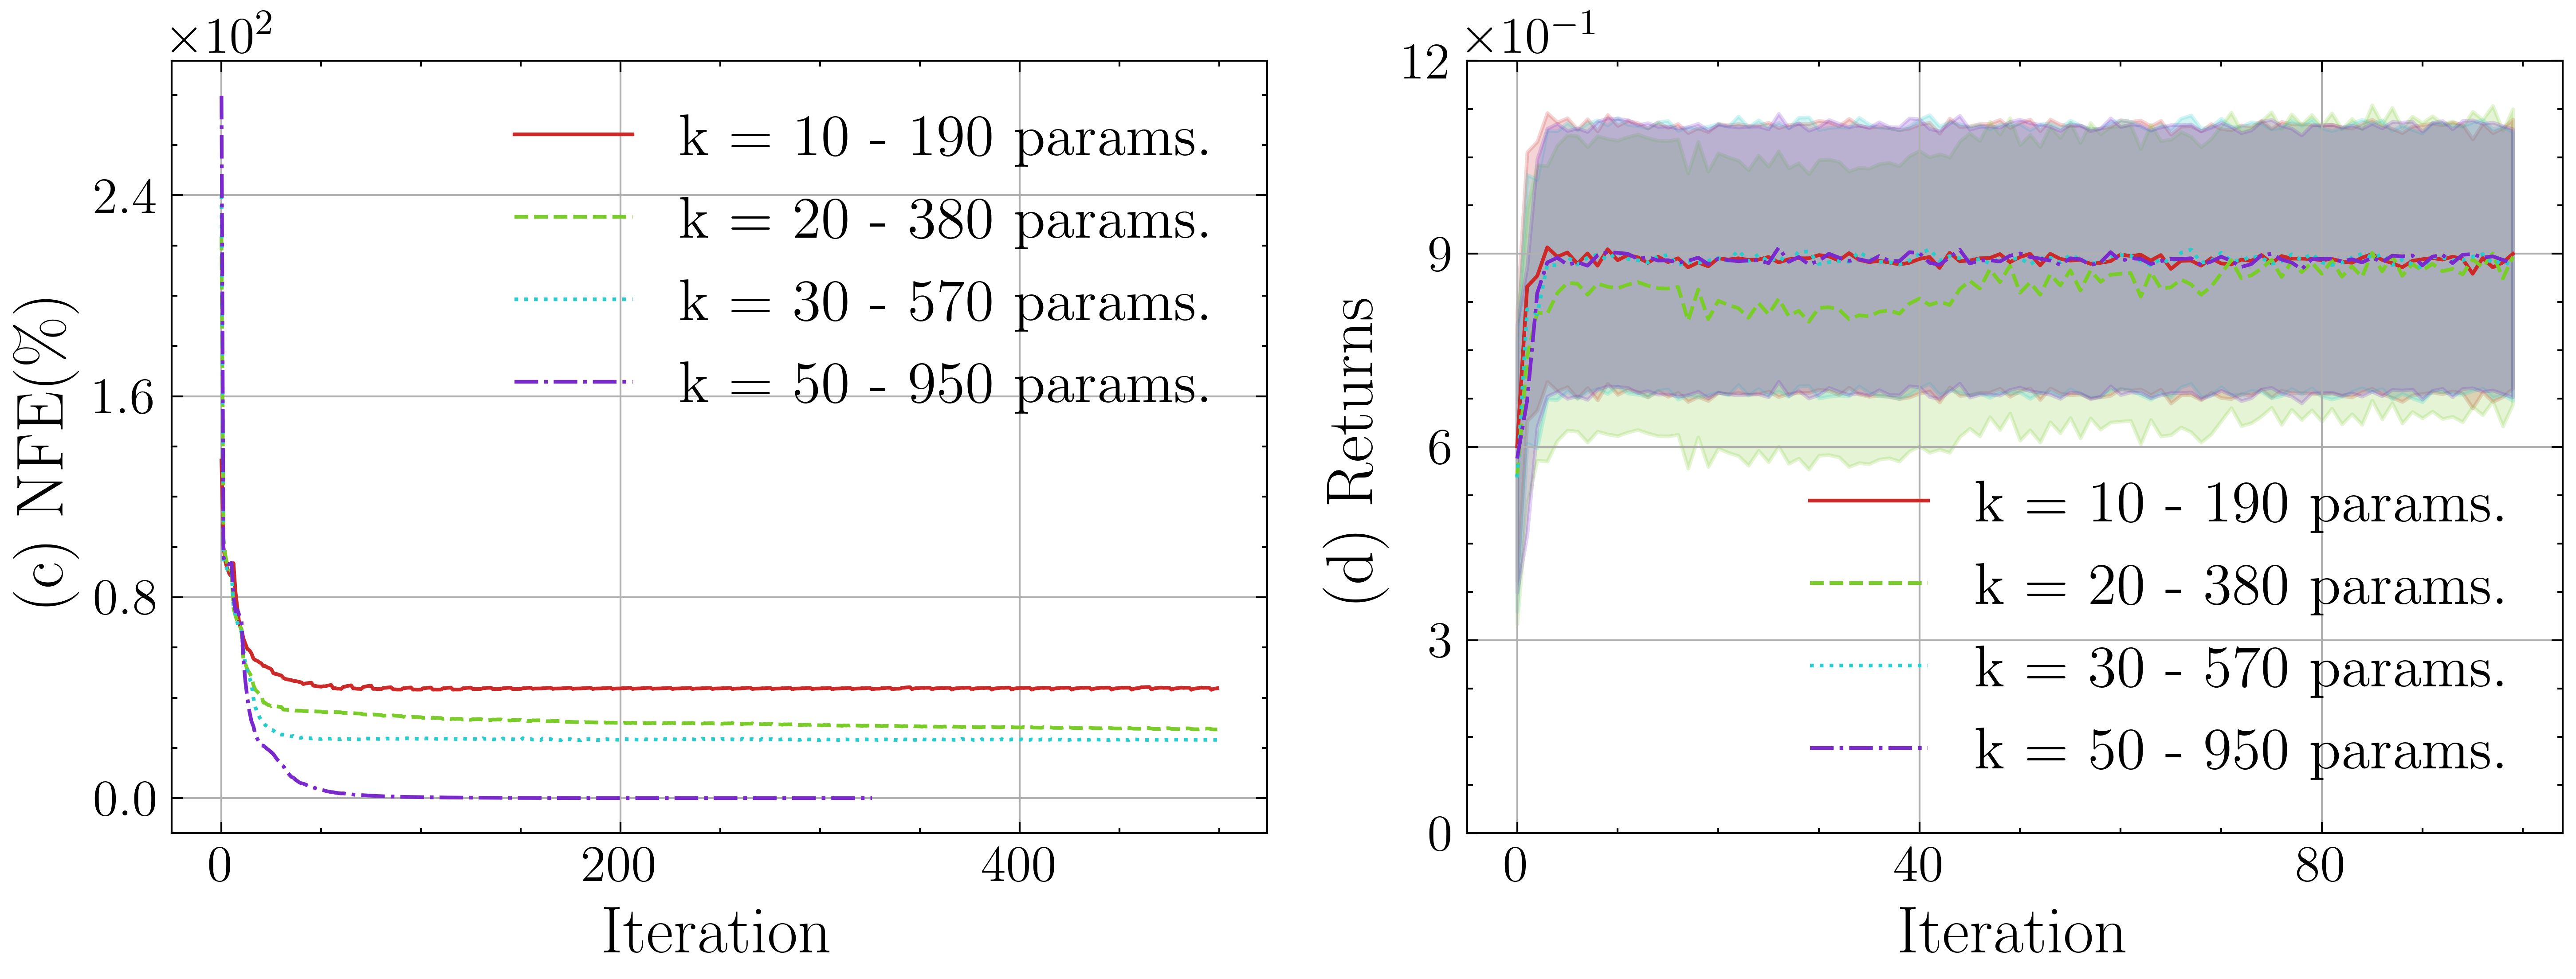

In [29]:
def generate_random_colors(num_colors):
    # Generar valores de matiz (H)
    hue_values = np.linspace(0, 1, num_colors, endpoint=False)

    # Fijar saturación (S) y valor (V) para obtener colores brillantes
    saturation = 0.8
    value = 0.8

    # Convertir de HSV a RGB
    hsv_colors = np.ones((num_colors, 3))
    hsv_colors[:, 0] = hue_values
    hsv_colors[:, 1] = saturation
    hsv_colors[:, 2] = value
    rgb_colors = matplotlib.colors.hsv_to_rgb(hsv_colors)

    return rgb_colors

colors = generate_random_colors(len(k_list))
# Crear subplots
with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 4])
    plt.rc('legend', fontsize=16)    # legend fontsize

    for k in range(len(k_list)):
        fo_values = fo_list[k]
        errors = errors_list[k]
        convs = conv_list[k]
        returns_mean = np.array(returns_mean_list[k])
        returns_std = np.mean(returns_std_list[k])

        # Segundo subplot: Coseno
        axes[0].plot(errors/(np.linalg.norm(Q_opt)/100),color = colors[k],label = f"k = {k_list[k]} - {(ENV.W*2  + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[0].xaxis.set_major_locator(MaxNLocator(nbins=3))
        #axes[0].set_xlim(0, num_iter)
        #axes[0].set_ylim(0, 200)
        axes[0].set_xlabel("Iteration",fontsize=18)
        axes[0].set_ylabel("(c) NFE(\%)",fontsize=18)
        axes[0].legend(loc='upper right')
        axes[0].grid(True)

        # Tercer subplot: Tangente
        axes[1].plot(returns_mean , color = colors[k], label = f"k = {k_list[k]} - {(ENV.W*2 + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[1].fill_between(
            range(len(returns_mean)),  # Eje X: índices de los valores
            returns_mean - returns_std,  # Límite inferior
            returns_mean + returns_std,  # Límite superior
            color=colors[k], alpha=0.2  # Opcional: color y transparencia
        )
        axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
        #axes[1].set_xlim(0, num_iter)
        axes[1].set_ylim(0, 1.2)
        axes[1].set_xlabel("Iteration",fontsize=18)
        axes[1].set_ylabel(r"(d) Returns ",fontsize=18)
        axes[1].legend(loc='lower right')
        axes[1].grid(True)

    # Ajustar el espacio entre subplots
    plt.tight_layout()

    # Mostrar la figura
    plt.show()

Plot de las matrices

In [ ]:
def plot_gridworld(W, mat_q_stationary, mat_q, mat_tlr):
    mat_r = np.zeros((W, W))
    mat_r[0, 0] = 0.5
    mat_r[-1, -1] = 1

    with plt.style.context(["science"], ["ieee"]):
        matplotlib.rcParams.update({"font.size": 14})

        fig, axarr = plt.subplots(2, 2, figsize=(6, 6), constrained_layout=True)

        vmin = 0.0
        vmax = 100.0

        cax1 = axarr[0, 0].imshow(mat_r, vmin=vmin, vmax=vmax, cmap="Reds")
        for i in range(W):
            for j in range(W):
                v = np.around(mat_r[i, j], 1)
                axarr[0, 0].text(j, i, v, ha="center", va="bottom", color="silver")
        axarr[0, 0].set_xlabel("(a)")

        axarr[0, 1].imshow(mat_q_stationary, vmin=vmin, vmax=vmax, cmap="Reds")
        for i in range(W):
            for j in range(W):
                v = np.around(mat_q_stationary[i, j], 1)
                axarr[0, 1].text(j, i, v, ha="center", va="bottom", color="silver")
        axarr[0, 1].set_xlabel("(b)")

        axarr[1, 0].imshow(mat_q, vmin=vmin, vmax=vmax, cmap="Reds")
        for i in range(W):
            for j in range(W):
                v = np.around(mat_q[i, j], 1)
                axarr[1, 0].text(j, i, v, ha="center", va="bottom", color="silver")
        axarr[1, 0].set_xlabel("(c)")

        axarr[1, 1].imshow(mat_tlr, vmin=vmin, vmax=vmax, cmap="Reds")
        for i in range(W):
            for j in range(W):
                v = np.around(mat_tlr[i, j], 1)
                axarr[1, 1].text(j, i, v, ha="center", va="bottom", color="silver")
        axarr[1, 1].set_xlabel("(d)")

        for ax in axarr.ravel():
            ax.set_xticks([])
            ax.set_yticks([])

        gap = 0.0
        width = 0.45
        height = 0.45

        axarr[0, 0].set_position([0, 0.5 + gap / 2, width, height])
        axarr[0, 1].set_position([0.5 + gap, 0.5 + gap / 2, width, height])
        axarr[1, 0].set_position([0, 0, width, height])
        axarr[1, 1].set_position([0.5 + gap, 0, width, height])

        fig.savefig("figures/fig_1.jpg", dpi=300)